NB: run `unpack_maalfrid.sh` before running this notebook!

In [2]:
# builds datastructure of translation pairs

pairs = {
    "en-nb": {"en": [], "nb": []},
    "en-da": {"en": [], "da": []},
    "en-sv": {"en": [], "sv": []},
    "nb-da": {"nb": [], "da": []},
    "nb-sv": {"nb": [], "sv": []},
    "sv-da": {"sv": [], "da": []}
}

import os
from translate.storage.tmx import tmxfile

folder = "ecdc-tm"

for file in os.listdir(folder):
    sourcelang, targetlang = file.split(".")[0].split("-")
    print("importing", sourcelang, targetlang)
    with open(folder+"/"+file, "r") as f:
        
        tmx_file = tmxfile(f, sourcelang, targetlang)
    for node in tmx_file.unit_iter():
        pairs[file.split(".")[0]][sourcelang].append(node.source)
        pairs[file.split(".")[0]][targetlang].append(node.target)

importing nb sv
importing sv da
importing en sv
importing en nb
importing en da
importing nb da


In [19]:
tall = 25
print(pairs["sv-da"]["sv"][tall])
print(pairs["sv-da"]["da"][tall])
for key in pairs.keys():
    print(key, len(pairs[key][key.split("-")[0]]))



                I själ och hjärta är jag läkare.



                I mit hjerte er jeg læge.


Ca. 15 % af patienterne får langvarige eller tilbagevendende symptomer i en periode på 6–9 måneder.

en-nb 2475
en-da 2505
en-sv 2467
nb-da 2169
nb-sv 2377
sv-da 2175


In [4]:
#copied from https://tfhub.dev/google/LaBSE/2

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Needed for loading universal-sentence-encoder-cmlm/multilingual-preprocess
import numpy as np

2023-10-25 13:49:13.844224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 13:49:13.888918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 13:49:13.889272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 13:49:15.290988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
from similarity_metrics import Similarity

In [6]:
# import preprocessor and LaBSE model
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

2023-10-25 13:49:18.488832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-25 13:49:18.490085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-25 13:49:18.490380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-25 13:49:18.491518: I tensorflow/core/

2023-10-25 13:49:28.933865: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1539542016 exceeds 10% of free system memory.


In [17]:
%%time

sim = Similarity(1)
from scipy.spatial.distance import cityblock
numberofsentencepairs = 9

for pair in pairs:

    sourcelang, targetlang = pairs[pair].keys()

    sourcesentences = pairs[pair][sourcelang][:numberofsentencepairs]
    targetsentences = pairs[pair][targetlang][:numberofsentencepairs]
    source_embeds = encoder(preprocessor(sourcesentences))["default"]
    target_embeds = encoder(preprocessor(targetsentences))["default"]

    euclideandistances = []    
    manhattandistances = []
    fracdistances = []
    for i in range(0, len(source_embeds)):
        manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
        euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
        fracdistances.append(sim.fractional_distance(source_embeds[i], target_embeds[i], 1))
    
    
    print("Average manhattan distance for " + pair + ":")
    print(sum(manhattandistances)/len(manhattandistances))
    print("Average euclidean distance for " + pair + ":")
    print(sum(euclideandistances)/len(euclideandistances))
    print("Average fractional distance for " + pair + ":")
    print(sum(fracdistances)/len(fracdistances))

    indexworst = euclideandistances.index(max(euclideandistances))
    indexbest = euclideandistances.index(min(euclideandistances))

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], "<->", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], "<->", targetsentences[indexbest])

    print()

Average manhattan distance for en-nb:
171.52250501844617
Average euclidean distance for en-nb:
7.877320183648004
Average fractional distance for en-nb:
113.69767803615994

Average manhattan distance for en-da:
144.22319878472223
Average euclidean distance for en-da:
6.728464974297418
Average fractional distance for en-da:
83.62568664550781

Average manhattan distance for en-sv:
168.55064137776694
Average euclidean distance for en-sv:
7.830674277411567
Average fractional distance for en-sv:
98.10431501600478

Average manhattan distance for nb-da:
115.69885338677301
Average euclidean distance for nb-da:
5.555069923400879
Average fractional distance for nb-da:
1.1144668791029189

Average manhattan distance for nb-sv:
104.45682610405817
Average euclidean distance for nb-sv:
5.136263476477729
Average fractional distance for nb-sv:
4.527372307247585

Average manhattan distance for sv-da:
136.57452477349176
Average euclidean distance for sv-da:
6.484276692072551
Average fractional distance fo

In [18]:
%%time

from scipy.spatial.distance import cityblock
numberofsentencepairs = 100

iterations = 1

for pair in pairs:
    if pair != "en-nb": 
        continue
    print(pair)
    sourcelang, targetlang = pairs[pair].keys()
    avgsman = []
    avgseuc = []

    for it in range(0, iterations):
        start = numberofsentencepairs*it
        end = numberofsentencepairs*(it+1) - 1
        print(start, end)
        sourcesentences = pairs[pair][sourcelang][start:end]
        targetsentences = pairs[pair][targetlang][start:end]
        print(sourcesentences[0])
        print(targetsentences[0])

        source_embeds = encoder(preprocessor(sourcesentences))["default"]
        target_embeds = encoder(preprocessor(targetsentences))["default"]

        euclideandistances = []    
        manhattandistances = []
        for i in range(0, len(source_embeds)):
            manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
            euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
        
        avgsman.append(sum(manhattandistances)/len(manhattandistances))
        avgseuc.append(sum(euclideandistances)/len(euclideandistances))
        
        rankeddistances = []
        for i in range(0, len(euclideandistances)):
            rankeddistances.append({"index": i, 
                                    "distance": euclideandistances[i], 
                                    "sentence_source": sourcesentences[i], 
                                    "sentence_target": targetsentences[i]
                                   })
        sorted_distances = sorted(rankeddistances, key=lambda x: x['distance'])

        for e in sorted_distances:
            print("Distance:", e["distance"])
            print(e["sentence_source"])
            print(e["sentence_target"])
            print()
        
        
    print(avgsman)
    print("Average manhattan distance for " + pair + ":")
    print(sum(avgsman)/len(avgsman))
    print("Average euclidean distance for " + pair + ":")
    print(sum(avgseuc)/len(avgseuc))
    
    #indexworst = euclideandistances.index(max(euclideandistances))
    #indexbest = euclideandistances.index(min(euclideandistances))

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], " <-> ", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], " <-> ", targetsentences[indexbest])

    print()

en-nb
0 99

The Knowledge and Resource Centre on Health Communication provides input to EU Member States and EEA/EFTA countries supporting them in sharing knowledge and experiences on health communication, particularly dedicated to communicable diseases.


Kunnskaps- og ressurssenteret for helsekommunikasjon kommer med innspill til medlemsstatene i EU og EØS/EFTA-landene og hjelper dem å dele kunnskap om og erfaringer med helsekommunikasjonsarbeid, særlig når det gjelder smittsomme sykdommer.



KeyboardInterrupt: 

In [89]:
en = "These examples of misuse promote the emergence and the selection of resistant bacteria."
da = "Disse eksempler repræsenterer et misbrug, der medvirker til, at resistente bakterier opstår og udvælges."
nb = "Dette er eksempler på feil bruk som bidrar til utviklingen av resistente bakterier."
sv = "Denna typ av missbruk främjar uppkomsten och urvalet av resistenta bakterier."
sv = "hva skjer i dag?"


en_embed = encoder(preprocessor([en]))["default"][0]
da_embed = encoder(preprocessor([da]))["default"][0]
nb_embed = encoder(preprocessor([nb]))["default"][0]
sv_embed = encoder(preprocessor([sv]))["default"][0]

print("en-da", cityblock(en_embed, da_embed))
print("sv-da", cityblock(sv_embed, da_embed))
print("nb-da", cityblock(nb_embed, da_embed))
print("en-sv", cityblock(en_embed, sv_embed))
print("nb-sv", cityblock(nb_embed, sv_embed))
print("en-nb", cityblock(en_embed, nb_embed))


en-da 167.68042
sv-da 393.72595
nb-da 221.2579
en-sv 436.93674
nb-sv 376.089
en-nb 280.53403


/home/jon/Projects/forprosjekt_master/venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


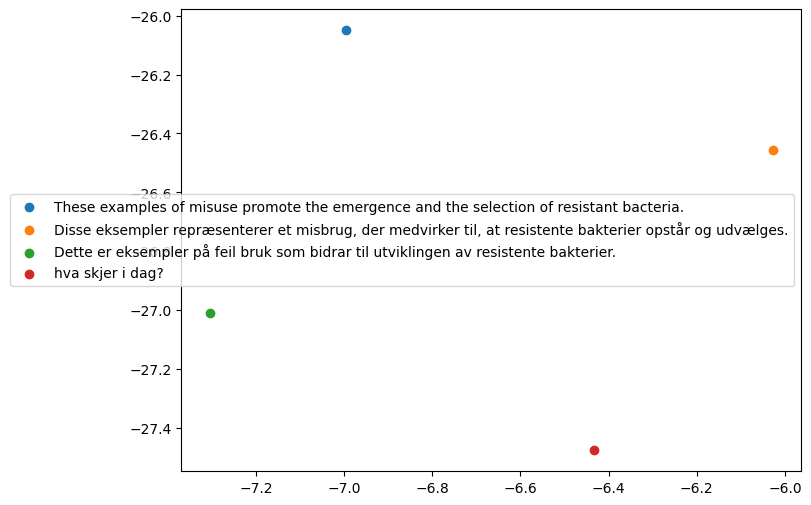

In [90]:
import tensorflow as tf
import umap
import numpy as np
import matplotlib.pyplot as plt

# Create a list of your tensors
tensors = [en_embed, da_embed, nb_embed, sv_embed]

# Define labels for your tensors
tensor_labels = [en, da, nb, sv]

# Combine and flatten tensors into a 2D array
data = np.vstack([tf.reshape(tensor, (-1,)).numpy() for tensor in tensors])

# Initialize a UMAP reducer instance with desired parameters
reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=2)

# Apply UMAP to the combined data
embedding = reducer.fit_transform(data)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each tensor's UMAP projection individually as dots with labels
for i, label in enumerate(tensor_labels):
    x, y = embedding[i, 0], embedding[i, 1]
    ax.scatter(x, y, label=label)

ax.legend()
plt.show()

In [10]:
num = 51
print(pairs["en-nn"]["en"][num])
print(pairs["en-nn"]["nn"][num])


EMS from analyses of variance (LS) to estimate variances (g and r).
* EMS frå variansanalyse (LS) til å estimera variansar (g og r).
